# Variational Auto Encoder

In [1]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Let's use the MNIST dataset because this is just an example showcase

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
x_train.shape

(60000, 784)

In [5]:
x_test.shape

(10000, 784)

## Network hyperparameters

In [6]:
input_shape = (original_dim, )
batch_size = 128
latent_dim = 2
epochs = 50

## The encoder model

In [7]:
inputs = Input(shape=input_shape,name='encoder_inputs')
x = Dense(512,activation='relu')(inputs)

z_mean = Dense(latent_dim, name='z_mean')(x) #Mean
z_log_sigma = Dense(latent_dim, name='z_log_sigma')(x) #Standard deviation

## Because VAE is a GAN, we can user these parameters to sample new similar points from the latent space

In [8]:
# reparameterization trick
# z = z_mean + sqrt(sigma)*eps
def sampling(args):
    
    z_mean,z_log_sigma = args
    
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    
    #Reparametrization trick
    epsilon = K.random_normal(shape=(batch,dim))
     
    
    return z_mean + K.exp(0.5*z_log_sigma) * epsilon

In [9]:
z = Lambda(sampling,output_shape=(latent_dim,), name='z')([z_mean,z_log_sigma])

## Encoding inputs to latent space

In [10]:
encoder = Model(inputs,[z_mean,z_log_sigma,z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_inputs[0][0]             
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

## The decoder model

In [11]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(512, activation='relu')(latent_inputs)
outputs = Dense(original_dim,activation='sigmoid')(x)

## Decoding latent space samples to outputs

In [12]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [13]:
outputs = decoder(encoder(inputs)[2]) #Position 2 is the z_samples generated by the sampling function

## The VAE model

In [14]:
vae = Model(inputs, outputs, name='vae') #encoder + decoder

## Now we have to build the VAE's most important feature, its loss function, which is a combination of the reconstruction loss and the KL divergence

In [15]:
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim #Apply to all pixels

In [16]:
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss,axis=-1)
kl_loss *= -0.5

In [17]:
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [18]:
vae.add_loss(vae_loss)

## Compile VAE model using ADAM optimizer

In [19]:
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


## Training VAE using MNIST data

In [20]:
vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,None),verbose=False)

## Let's see how the latent space looks

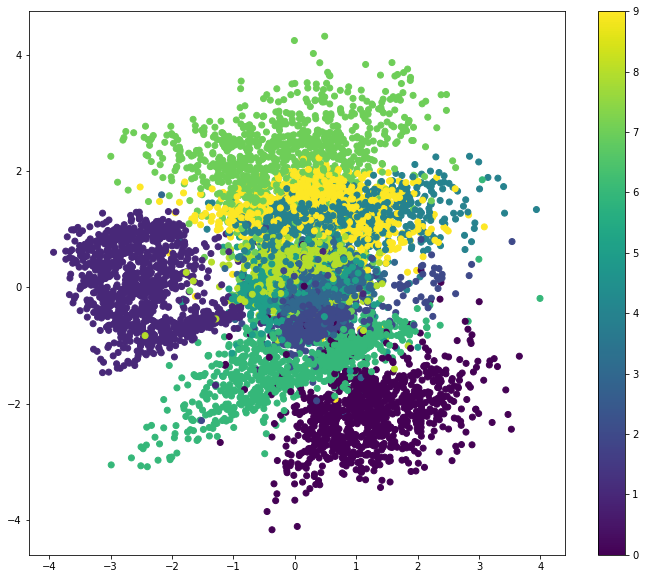

In [21]:
z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.show()

#### As you can see , thanks to reconstruction loss, the space is clusterized 

#### And thanks to KL divergence, it is dense. Instead of gaps between clusters, we have smooth mix of features, so the decoder can undestand

#### Finally, our latent space has cluster forming nature and dense packing nature

## We can generate digits using VAE

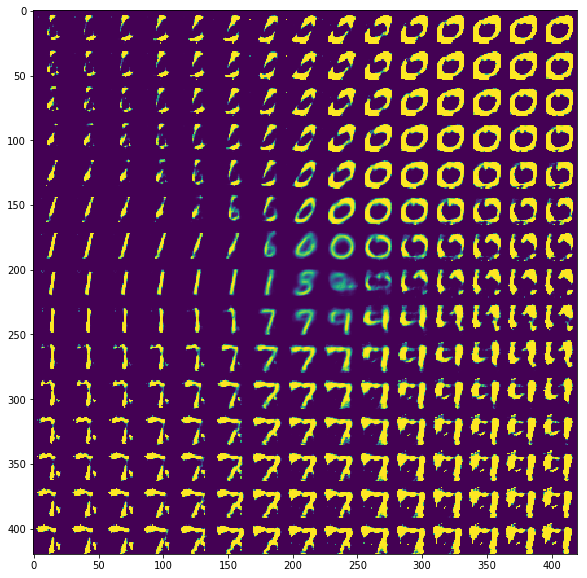

In [22]:
n = 15  
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()